## Import all the requiered libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Explore and prepare the dataset

In [2]:
df = pd.read_csv("dataset/dataset_membrane_.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SW         5216 non-null   float64
 1   MWCO       5216 non-null   int64  
 2   CA         5216 non-null   int64  
 3   ZP         5216 non-null   float64
 4   Permeance  5216 non-null   float64
 5   Rejection  5216 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 244.6 KB


In [4]:
df.head(5)

,SW,MWCO,CA,ZP,Permeance,Rejection
0,1.50778,350,87,-15.0,48.058984,0.742500
1,1.50778,350,87,-15.0,48.058984,0.351755
2,1.50778,350,87,-15.0,48.058984,0.364472
3,1.50778,350,87,-15.0,48.058984,0.232885
4,1.50778,350,87,-15.0,48.058984,0.098254


In [5]:
type(df['SW'][0])

numpy.float64

In [7]:
X = df.drop(['Permeance', 'Rejection'], axis=1)
y = df[['Permeance', 'Rejection']]

**Lets use Min Max Normalization to normalize all the seven features, transforming their values into a scale between 0 and 1.**

In [8]:
def normalize(dataset):
    data_normalized = ((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return data_normalized

In [9]:
features = normalize(df)
features

,SW,MWCO,CA,ZP,Permeance,Rejection
0,0.454667,0.571429,1.0,0.616438,0.741910,0.817718
1,0.454667,0.571429,1.0,0.616438,0.741910,0.541114
2,0.454667,0.571429,1.0,0.616438,0.741910,0.550116
3,0.454667,0.571429,1.0,0.616438,0.741910,0.456967
4,0.454667,0.571429,1.0,0.616438,0.741910,0.361663
...,...,...,...,...,...,...
5211,1.000000,0.142857,0.0,0.616438,0.047235,0.734593
5212,1.000000,0.142857,0.0,0.616438,0.047235,0.300520
5213,1.000000,0.142857,0.0,0.616438,0.047235,0.369577
5214,1.000000,0.142857,0.0,0.616438,0.047235,0.633118


## Create a train (70%) and a test (30%) set 

In [10]:
X = features[['SW','MWCO', 'CA', 'ZP']].to_numpy()
X[:5]

array([[0.45466716, 0.57142857, 1.        , 0.61643836],
       [0.45466716, 0.57142857, 1.        , 0.61643836],
       [0.45466716, 0.57142857, 1.        , 0.61643836],
       [0.45466716, 0.57142857, 1.        , 0.61643836],
       [0.45466716, 0.57142857, 1.        , 0.61643836]])

In [11]:
y= y.to_numpy()
y[:5]

array([[48.05898411,  0.74249975],
       [48.05898411,  0.35175509],
       [48.05898411,  0.36447169],
       [48.05898411,  0.23288501],
       [48.05898411,  0.09825405]])

In [12]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


## Numpy arrays to Pytorch tensors train

In [13]:
# Convert the data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


In [15]:
# Define the LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

In [16]:
# Define model parameters
input_size = X.shape[1]
hidden_size = 64
num_layers = 2
output_size = 2

In [17]:
# Instantiate the model
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size)

In [18]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [19]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.unsqueeze(1))  # Add sequence length dimension
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.unsqueeze(1))  # Add sequence length dimension
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [1/100], Train Loss: 47.8370, Val Loss: 43.0928
Epoch [2/100], Train Loss: 47.7181, Val Loss: 42.9793
Epoch [3/100], Train Loss: 47.5953, Val Loss: 42.8568
Epoch [4/100], Train Loss: 47.4625, Val Loss: 42.7200
Epoch [5/100], Train Loss: 47.3141, Val Loss: 42.5640
Epoch [6/100], Train Loss: 47.1446, Val Loss: 42.3843
Epoch [7/100], Train Loss: 46.9490, Val Loss: 42.1764
Epoch [8/100], Train Loss: 46.7224, Val Loss: 41.9366
Epoch [9/100], Train Loss: 46.4601, Val Loss: 41.6615
Epoch [10/100], Train Loss: 46.1584, Val Loss: 41.3498
Epoch [11/100], Train Loss: 45.8150, Val Loss: 41.0024
Epoch [12/100], Train Loss: 45.4302, Val Loss: 40.6240
Epoch [13/100], Train Loss: 45.0077, Val Loss: 40.2227
Epoch [14/100], Train Loss: 44.5552, Val Loss: 39.8086
Epoch [15/100], Train Loss: 44.0819, Val Loss: 39.3913
Epoch [16/100], Train Loss: 43.5970, Val Loss: 38.9829
Epoch [17/100], Train Loss: 43.1124, Val Loss: 38.6010
Epoch [18/100], Train Loss: 42.6459, Val Loss: 38.2669
Epoch [19/100], Tra

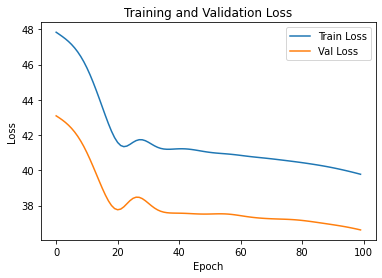

In [20]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
# Save ground truth and predictions to an Excel file
with torch.no_grad():
    predictions = model(X_val.unsqueeze(1)).numpy()
    df = pd.DataFrame({'Permeance GroundTruth': y_val[:, 0].numpy(),
                       'Permeance Prediction': predictions[:, 0],
                       'Rejection GroundTruth': y_val[:, 1].numpy(),
                       'Rejection Prediction': predictions[:, 1]})
    df.to_excel('predictions_two_outputs.xlsx', index=False)